# **PREVENDO DEMANDA DE TRANSPORTES PRIVADOS COM LSTM (RNN)**
**Redes Neurais para Previsão de Requisições de Táxis utilizando NYC Open Data**

---
Realizado por **Samuel França da Costa Pedrosa**

**Linkedin**: *linkedin.com/in/samuelfrancapedrosa*

**GitHub**: *github.com/sampedrosa*

---

---
# **Objetivo**
---
O Long-Short-Term Memory (LSTM) é uma Rede Neural Recorrente (RNN) que utiliza o armazenamento de uma pequena parte do processamento de informações na memória dos neurônios durando por vários passos do método. Como toda RNN, é idealmente aplicável para features e targets seriais, geralmente vinculados ao tempo.

Dessa maneira, a aplicabilidade desse método é imensurável e é utilizado nesse projeto para prever demanda de transporte privado como taxis e ubers, uma vez que há uma quantidade de requisitos dessas corridas por tempo em localizações específicas. Ou seja, aplicar uma rede neural em um conjunto de dados formatados para identificar as tendências, sazonalidades e até mesmo comportamentos em eventos probabilisticos em uma função de demanda por tempo para cada localidade.




É utilizado nesse projeto uma base de dados aberta e disponibilizada pela prefeitura de Nova York, chamada de **NYC Open Data** contendo diversos datasets sobre a cidade, inclusive o de corridas de taxi (Yellow Taxi). Como é uma cidade culturalmente adepta por viagens de taxi, o dataset é muito grande, chegando em aproximadamente 100 milhões de registros por ano (10GB), assim, nesse projeto, será utilizada a base de dados apenas do ano de [2019](https://data.cityofnewyork.us/Transportation/2019-Yellow-Taxi-Trip-Data/2upf-qytp), mas é aplicável a outros anos como também suas uniões.

Para a compreensão do funcionamento do LSTM nesse caso, é necessário compreender que ele utiliza um conjunto de entradas em tempos anteriores e um conjunto de saída em tempos futuros ou de testes. Ou seja, o modelo treinado é capaz de prever o comportamento da série-temporal apenas com alguns valores anteriores.

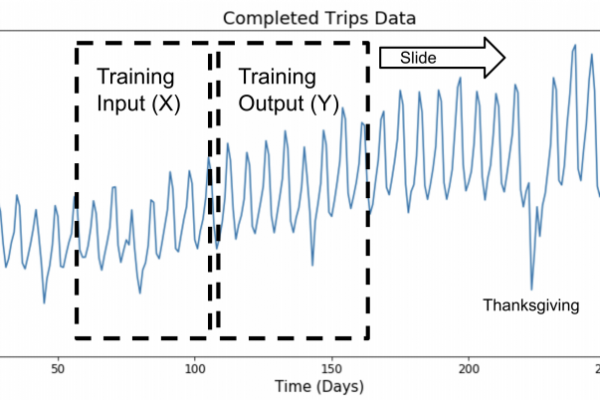

Além disso o dataset contem a localização do começo da viagem de taxi, separando a grande Nova York em 263 zonas, garantindo uma forma de possibilitar a previsão da demanda por localidade. O [mapa de dados](https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc) também é disponibilizado pela NYC Open data.

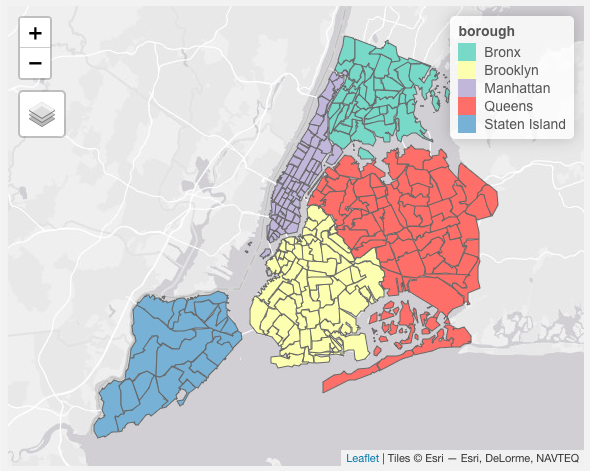

Como é um projeto que envolve tanto a área de dados como machine learning, é necessário algumas instalações de pacotes e bibliotecas:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

---
# **Base de Dados**
---

In [ ]:
!pip install -q sodapy

In [ ]:
from sodapy import Socrata

# Socrata API Example
client = Socrata("data.cityofnewyork.us", None)
client.timeout = 100
pd.DataFrame(client.get("biws-g3hs", limit=100)).head()

vendorid     tpep_pickup_datetime    tpep_dropoff_datetime passenger_count  \
0        1  2017-02-07T22:13:31.000  2017-02-07T22:56:05.000               1   
1        2  2017-02-07T22:13:31.000  2017-02-07T22:32:45.000               2   
2        2  2017-02-07T22:13:31.000  2017-02-07T22:29:42.000               3   
3        2  2017-02-07T22:13:32.000  2017-02-07T22:18:38.000               1   
4        1  2017-02-07T22:13:33.000  2017-02-07T22:16:12.000               4   

  trip_distance ratecodeid store_and_fwd_flag pulocationid dolocationid  \
0         18.40          2                  N          132          161   
1          4.03          1                  N          107           43   
2          5.16          1                  N          143           13   
3          0.75          1                  N          142          239   
4          0.50          1                  N          151          238   

  payment_type fare_amount extra mta_tax tip_amount tolls_amount  \
0            1          52     0     0.5      10.55            0   
1            1          16   0.5     0.5        1.7            0   
2            1          18   0.5     0.5       3.86            0   
3            2         5.5   0.5     0.5          0            0   
4            2           4   0.5     0.5          0            0   

  improvement_surcharge total_amount  
0                   0.3        63.35  
1                   0.3           19  
2                   0.3        23.16  
3                   0.3          6.8  
4                   0.3          5.3

Para o treinamento do modelo iremos restrigir os dados obtidos pela API Socrata do dataset NYC Open Data. Por meio de uma consulta, selecionaremos o horário de partida do táxi com restrição do id da zona.


In [ ]:
URL = "data.cityofnewyork.us"
TIMEOUT = 60000
LIMIT = 200000000

def getZoneData(zone_id, address): # Get Trips from a Location
  client = Socrata(URL, None)
  client.timeout = TIMEOUT
  results = client.get(address, select="tpep_pickup_datetime", where="PULocationID =" + str(zone_id), order="tpep_pickup_datetime ASC", limit=LIMIT)
  return pd.DataFrame(results)

df = getZoneData(237, "2upf-qytp")
df

tpep_pickup_datetime
0        2008-12-31T23:02:28.000
1        2008-12-31T23:04:37.000
2        2008-12-31T23:07:53.000
3        2008-12-31T23:14:10.000
4        2009-01-01T00:02:18.000
...                          ...
3641677  2020-04-11T22:43:14.000
3641678  2020-04-12T01:08:56.000
3641679  2020-04-16T07:30:29.000
3641680  2020-07-04T15:03:19.000
3641681  2058-12-02T18:49:27.000

[3641682 rows x 1 columns]

---
# **Tratamento dos Dados**
---


In [ ]:
PERIOD = 5 # Group of PERIOD Minutes
DAY = int(24*60/PERIOD)
WEEK = int(7*DAY)
YEAR = int(365*DAY)

# Date-Time Formatting
df.columns = ["Date"]
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%dT%H:%M:%S.%f")

# Data Processing
df = df.loc[((df["Date"] >= "2019-01-01 00:00:00")
              & (df["Date"] <= "2019-12-31 23:59:59"))]

# Period Formatting
data = pd.DataFrame({'Time':[i for i in range(YEAR)]})
copy = df.copy()

# Period Definition
copy['Time'] = round((copy['Date']-(pd.to_datetime("2019-01-01 00:00:00"))).dt.total_seconds()/int(60*PERIOD)).astype(int)
copy

<ipython-input-101-b44747d709dd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%dT%H:%M:%S.%f")


Date    Time
32      2019-01-01 00:00:00       0
33      2019-01-01 00:00:11       0
34      2019-01-01 00:00:37       0
35      2019-01-01 00:01:19       0
36      2019-01-01 00:02:38       1
...                     ...     ...
3641655 2019-12-31 23:56:17  105119
3641656 2019-12-31 23:57:01  105119
3641657 2019-12-31 23:57:07  105119
3641658 2019-12-31 23:58:01  105120
3641659 2019-12-31 23:58:52  105120

[3641628 rows x 2 columns]

In [ ]:
# All data must be of the same lenght with all periods (older date to a newest date)
data = pd.DataFrame(pd.concat([data['Time'], copy['Time']], axis=0).sort_values())
data.columns = ['Time']
request = list(data.groupby('Time').size().values - 1)
data = pd.DataFrame({'Request': request})
data

Request
0             4
1            15
2            33
3            36
4            48
...         ...
105116       23
105117       10
105118       12
105119       13
105120        1

[105121 rows x 1 columns]

---
# **Análise dos Dados**
---

<Axes: ylabel='Request'>

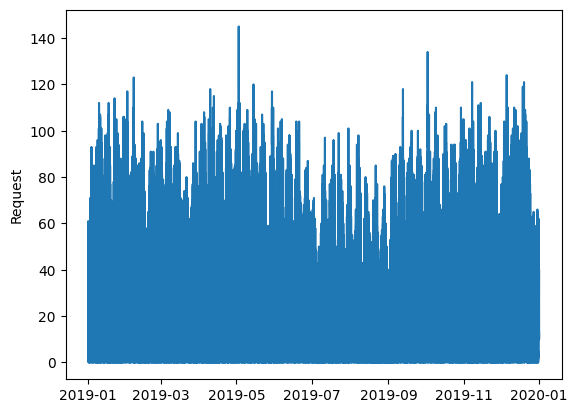

In [ ]:
from datetime import datetime, timedelta

def getDate(start, end):
  time_period = timedelta(minutes=PERIOD)
  now = start
  while now <= end:
    yield now
    now += time_period

first, last = "2019-01-01 00:00:00", "2019-12-31 23:59:59"
dates = getDate(pd.to_datetime(first), pd.to_datetime(last))
sns.lineplot(x=[date for date in dates], y=data['Request'][:-1])

<Axes: >

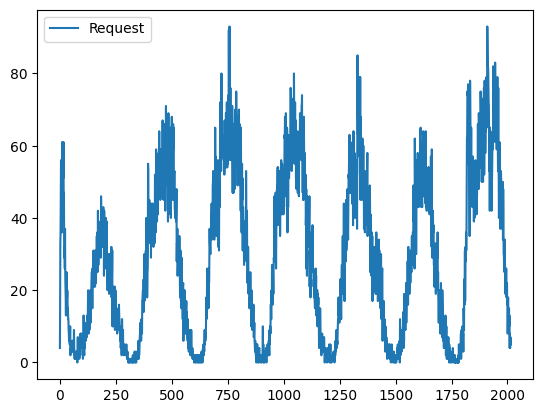

In [ ]:
sns.lineplot(data[:WEEK])

<Axes: >

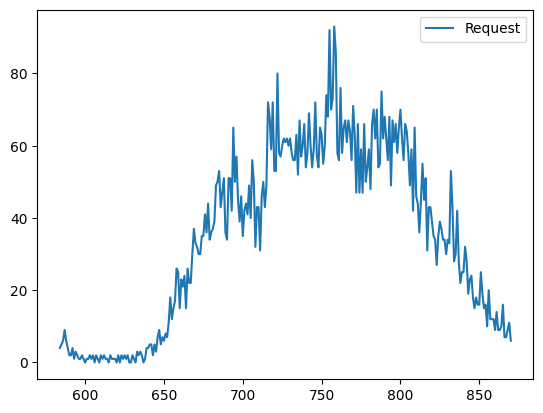

In [ ]:
sns.lineplot(data[:DAY])

---
# **Formatação e Treinamento do Modelo**
---

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data = data['Request'].to_numpy()
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1,1))

In [ ]:
X, y = [], []
array = data.reshape(-1,)

for i in range(len(array)-(WEEK+DAY)):
    row = [[j] for j in array[i:i+WEEK]]
    X.append(row)
    y.append(array[i+WEEK:i+(WEEK+DAY)])

X, y = np.array(X), np.array(y)  # Input and Output Defined
X.shape, y.shape

((34273, 672, 1), (34273, 96))

In [ ]:
TRAIN_PTG = 0.83  # Percentage of the Data for Training

train_size = int(len(X)*TRAIN_PTG)
test_size = len(X) - train_size

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28446, 672, 1), (5827, 672, 1), (28446, 96), (5827, 96))

In [ ]:
!pip install -q tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

TRAIN_PTG = 0.83  # Percentage of the Data for Training
NEURONS = 32  # Units of Neurons
EPOCHS = 4  # Number os Epochs
BATCH = 1  # Batchs per Execution
LEARN = 0.0001  # Learning Rate

model = Sequential()
model.add(InputLayer((WEEK,1)))
model.add(LSTM(NEURONS))
model.add(Dense(int(DAY*8), 'relu'))
model.add(Dense(DAY, 'linear'))
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=LEARN), metrics=[RootMeanSquaredError()])
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, verbose=1)
predicts = model.predict(X_test)

Epoch 1/4
28446/28446 [==============================] - 4357s 153ms/step - loss: 0.0110 - root_mean_squared_error: 0.1049
Epoch 2/4
28446/28446 [==============================] - 4239s 149ms/step - loss: 0.0079 - root_mean_squared_error: 0.0887
Epoch 3/4
28446/28446 [==============================] - 3843s 135ms/step - loss: 0.0064 - root_mean_squared_error: 0.0797
Epoch 4/4
183/183 [==============================] - 11s 56ms/step


---
# **Validação do Modelo**
---

<Axes: >

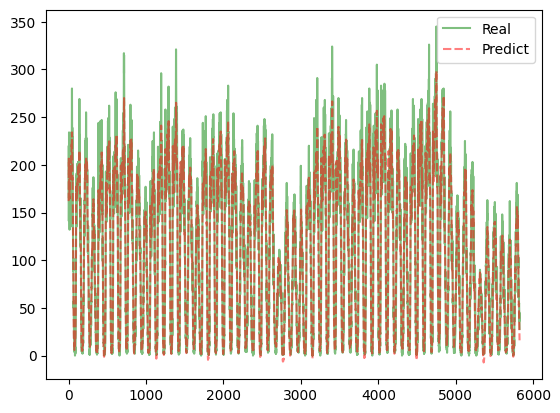

In [ ]:
y_real = pd.DataFrame(scaler.inverse_transform(y_test[:-2]))[[0]].values.reshape(-1,)
y_pred = pd.DataFrame(scaler.inverse_transform(predicts[1:-1]))[[0]].values.reshape(-1,)
compare = pd.DataFrame({'Real': y_real, "Predict": y_pred})
sns.lineplot(compare, palette=['green', 'red'], alpha=0.5)

<Axes: >

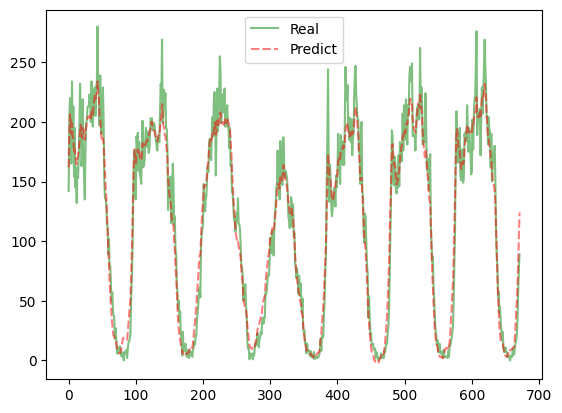

In [ ]:
sns.lineplot(compare[:WEEK], palette=['green', 'red'], alpha=0.5)

<Axes: >

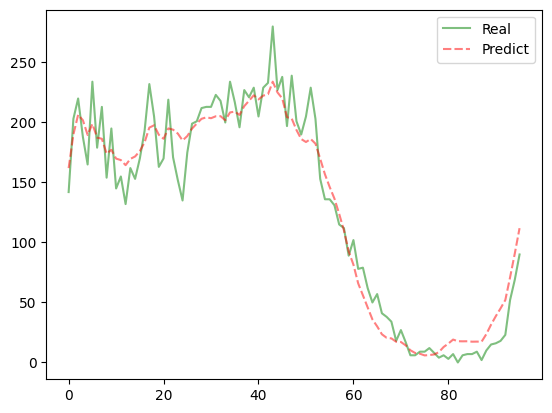

In [ ]:
sns.lineplot(compare[:DAY], palette=['green', 'red'], alpha=0.5)

In [ ]:
from sklearn.metrics import r2_score

loss, rmse = model.evaluate(X_test, y_test)
errors = compare['Real'] - compare['Predict']
absmean = abs(errors).mean()
std = np.std(errors)
r2 = r2_score(y_real, y_pred)
print(f'Erro Absoluto: {absmean:.4} \nDesvio Padrão: {std:.4} \nLoss: {loss:.4} \nRMSE: {rmse:.4} \nR2: {r2:.4}')

183/183 [==============================] - 11s 59ms/step - loss: 0.0075 - root_mean_squared_error: 0.0867
Erro Absoluto: 11.59 
Desvio Padrão: 15.45 
Loss: 0.007511 
RMSE: 0.08667 
R2: 0.9645


---
# **Aplicação**
---

Com a análise e modelagem condizentes com os objetivos do projeto, basta agora unir todos os códigos e aplicar para cada zona de táxi. Entretando, **não é recomendável compilar pelo Google Colab**, uma vez que há uma demanda muito grande de processamento, RAM e tempo, garantindo mais segurança e velocidade usando IDEs ou Jupyter em computadores com boas CPUS ou GPUS. Principalmente para valores pequenos do período e grandes camadas da redes neurais.



In [ ]:
!pip install -q sodapy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sodapy import Socrata

In [ ]:
URL = "data.cityofnewyork.us"
TOKEN = None
TIMEOUT = 60000
LIMIT = 200000000

TRAIN_PTG = 0.83  # Percentage of the Data for Training
NEURONS = 32  # Units of Neurons
EPOCHS = 3  # Number os Epochs
BATCH = 1  # Batchs per Execution
LEARN = 0.0001  # Learning Rate
PERIOD = 30  # Group of Minutes for Index

DAY = int(24*60/PERIOD)
WEEK = int(7*DAY)
YEAR = int(365*DAY)

In [ ]:
def getZoneData(zone_id, address): # Get Trips from a Location
  client = Socrata(URL, None)
  client.timeout = TIMEOUT
  results = client.get(address, select="tpep_pickup_datetime", where="PULocationID =" + str(zone_id), order="tpep_pickup_datetime ASC", limit=LIMIT)
  return pd.DataFrame(results)

def dataProcessing(dataframe): # Processing inviable data to a compatible format
  dataframe["tpep_pickup_datetime"] = pd.to_datetime(dataframe["tpep_pickup_datetime"], format="%Y-%m-%dT%H:%M:%S.%f")
  dataframe = dataframe.loc[((dataframe["tpep_pickup_datetime"] >= "2019-01-01 00:00:00")
                              & (dataframe["tpep_pickup_datetime"] <= "2019-12-31 23:59:59"))]

  data = pd.DataFrame({'Time':[i for i in range(YEAR)]})
  copy = dataframe.copy()
  copy['Time'] = round((copy["tpep_pickup_datetime"]-(pd.to_datetime("2019-01-01 00:00:00"))).dt.total_seconds()/int(60*PERIOD)).astype(int)
  data = pd.DataFrame(pd.concat([data['Time'], copy['Time']], axis=0).sort_values())
  data.columns = ['Time']
  request = list(data.groupby('Time').size().values - 1)
  data = pd.DataFrame({'Request': request})

  return data['Request'].to_numpy()

def getXY(dataframe): # Get Input and Output for the model
    X, y = [], []
    array = dataframe.reshape(-1,)

    for i in range(len(array)-(WEEK+DAY)):
        row = [[j] for j in array[i:i+WEEK]]
        X.append(row)
        y.append(array[i+WEEK:i+(WEEK+DAY)])

    return np.array(X), np.array(y)

In [ ]:
def nycLSTM(time, zones, address): # Use LSTM in one taxi zone per execution, until all predicts are made
    zones_real, zones_predict = pd.DataFrame([]), pd.DataFrame([])
    zones_real.index.name, zones_predict.index.name = 'Period', 'Period'

    for zone in zones:
      # Data Collect
      dataset = getZoneData(zone, address)
      time_index = round(((pd.to_datetime(time) - pd.to_datetime("2019-01-01 00:00:00")).total_seconds()/(60*PERIOD)) - YEAR*TRAIN_PTG)

      # Data Processing
      if data.empty:
        zones_real["Zone " + str(zone)] = [0] * DAY
        zones_predict["Zone " + str(zone)] = [0] * DAY
        zones_real.to_csv("zone_real.csv")
        zones_predict.to_csv("zone_pred.csv")
        continue
      data = dataProcessing(dataset)

      # Data Formatting
      scaler = MinMaxScaler(feature_range=(0, 1))
      data = scaler.fit_transform(data.reshape(-1,1))
      X, y = getXY(data)
      train_size = int(len(X)*TRAIN_PTG)
      test_size = len(X) - train_size
      X_train, y_train = X[:train_size], y[:train_size]
      X_test, y_test = X[train_size:], y[train_size:]

      # Modeling and Training
      model = Sequential()
      model.add(InputLayer((WEEK,1)))
      model.add(LSTM(NEURONS))
      model.add(Dense(int(DAY*8), 'relu'))
      model.add(Dense(DAY, 'linear'))
      model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=LEARN), metrics=[RootMeanSquaredError()])
      model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, verbose=1)
      predicts = model.predict(X_test)

      # Saving Results
      y_real = pd.DataFrame(scaler.inverse_transform(y_test[:-2]))[[0]].values.reshape(-1,)
      y_pred = pd.DataFrame(scaler.inverse_transform(predicts[1:-1]))[[0]].values.reshape(-1,)
      zones_real["Zone " + str(zone)] = y_real[time_index:time_index+DAY].reshape(-1,)
      zones_predict["Zone " + str(zone)] = y_pred[time_index:time_index+DAY].reshape(-1,)

      zones_real.to_csv("zones_real.csv")
      zones_predict.to_csv("zones_pred.csv")

    return zones_real, zones_predict

In [ ]:
zonelist = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/taxi-zone-lookup.csv")
#df_real, df_predict = nycLSTM("2019-12-04 00:01:00", zonelist['LocationID'].values, "2upf-qytp")
df_real, df_predict = nycLSTM("2019-12-04 00:01:00", zonelist['LocationID'], "2upf-qytp")

df_real.to_csv("realNYC.csv")
df_predict.to_csv("predNYC.csv")

---
# **Geração do Mapa e Resultados**
---

In [ ]:
#realNYC, predNYC = nycLSTM(START_PREDICTION, zonelist)

realNYC = pd.read_csv('/content/realNYC.csv').abs() # DataFrame with the real values to compare
predNYC = pd.read_csv('/content/predNYC.csv').abs() # DataFrame with all the predictions

for col in realNYC.columns:
  if not col.startswith('Zone'):
    realNYC.drop(col, axis=1, inplace=True)
    predNYC.drop(col, axis=1, inplace=True)

predNYC

Zone 1    Zone 2    Zone 3     Zone 4    Zone 5    Zone 6    Zone 7  \
0   0.492392  0.004209  0.203726  12.308323  0.001193  0.015357  9.654832   
1   0.516344  0.004211  0.197008  12.544374  0.002609  0.015316  7.770793   
2   0.468919  0.004214  0.190300  12.944556  0.005506  0.015280  6.417095   
3   0.429187  0.004218  0.183569  12.367528  0.008258  0.015249  6.217534   
4   0.461269  0.004222  0.174715  10.740242  0.010539  0.015223  5.265024   
5   0.464236  0.004225  0.165373   8.021477  0.012176  0.015201  4.535079   
6   0.478730  0.004229  0.157147   6.789292  0.013160  0.015182  4.206214   
7   0.527493  0.004231  0.151524   5.615918  0.013814  0.015166  4.077826   
8   0.599103  0.004234  0.145279   4.566571  0.014217  0.015153  4.208877   
9   0.669501  0.004236  0.135476   6.198574  0.014450  0.015143  4.850609   
10  0.777234  0.004237  0.129021   4.761167  0.014558  0.015134  4.732816   
11  0.869521  0.004239  0.124897   4.190933  0.014578  0.015126  4.877584   
12  0.942499  0.004240  0.120620   4.321115  0.014553  0.015120  4.627623   
13  1.011192  0.004240  0.116615   4.936972  0.014514  0.015115  4.499644   
14  1.099486  0.004241  0.140036   4.417637  0.014469  0.015111  4.820106   
15  1.141560  0.004241  0.126460   3.679163  0.014420  0.015108  4.677615   
16  1.150413  0.004242  0.113892   3.968676  0.014373  0.015106  4.575029   
17  1.196964  0.004242  0.104605   4.099619  0.014317  0.015103  3.857586   
18  1.128472  0.004242  0.122463   4.108090  0.014266  0.015102  3.369819   
19  1.051460  0.004242  0.109044   4.835064  0.014220  0.015101  3.232027   
20  1.002954  0.004242  0.098022   6.505129  0.014180  0.015100  2.789417   
21  0.920301  0.004242  0.089503   6.735616  0.014145  0.015099  2.745055   
22  0.769114  0.004242  0.104855   7.081445  0.014115  0.015098  2.392094   
23  0.623141  0.004242  0.092942   7.767550  0.014090  0.015098  2.082301   
24  0.473295  0.004242  0.087010   7.342309  0.014069  0.015097  2.402434   
25  0.357627  0.004242  0.078706   7.823045  0.014051  0.015097  2.392024   
26  0.267180  0.004242  0.068047   7.743700  0.014037  0.015097  2.499527   
27  0.170484  0.004243  0.058147   8.528329  0.014024  0.015097  2.658596   
28  0.104571  0.029315  0.050736  11.055869  0.014014  0.015097  3.449275   
29  0.053741  0.022226  0.043487  10.624808  0.014006  0.015097  3.816963   
30  0.024708  0.017354  0.056674  10.560387  0.014000  0.015097  3.844964   
31  0.012983  0.013882  0.051580  10.453059  0.013994  0.015097  3.386150   
32  0.002974  0.011096  0.048453   8.824783  0.013990  0.015097  3.393177   
33  0.017879  0.008833  0.045153   6.486795  0.013986  0.015097  3.173288   
34  0.030647  0.007304  0.043517   4.481678  0.013984  0.015097  4.114249   
35  0.040778  0.006232  0.044505   5.052021  0.013982  0.015097  3.940389   
36  0.078234  0.005561  0.046016   4.042757  0.013980  0.015097  3.159935   
37  0.129836  0.005004  0.048649   2.542603  0.013978  0.015097  3.134951   
38  0.194514  0.004715  0.053731   1.848378  0.013977  0.015097  3.568425   
39  0.268672  0.004517  0.060413   1.927399  0.013977  0.015097  3.810552   
40  0.340070  0.004391  0.067700   2.478880  0.013976  0.015097  4.919038   
41  0.413751  0.004325  0.116251   3.062042  0.013975  0.015097  5.454883   
42  0.486165  0.004286  0.122896   4.502514  0.013975  0.015097  5.597820   
43  0.556301  0.004258  0.134940   4.406537  0.013975  0.015097  6.959760   
44  0.603876  0.004236  0.146889   4.123035  0.013975  0.015097  8.549041   
45  0.626193  0.004217  0.230785   5.736663  0.013975  0.015097  9.232060   
46  0.655558  0.004208  0.215433   8.060287  0.013974  0.015097  9.931548   
47  0.641433  0.004209  0.237281   9.378219  0.013974  0.015097  9.577220   

      Zone 8    Zone 9   Zone 10  ...  Zone 256  Zone 257  Zone 258  Zone 259  \
0   0.039718  0.141100  1.583729  ...  0.356839  0.169991  0.100431  0.148811   
1   0.039715  0.129921  1.729396  ...  0.310837  0.160548  0.086312  0

In [ ]:
from sklearn.metrics import r2_score

abserrors = abs(realNYC - predNYC)
prop_mae = abserrors.mean()/(realNYC.mean())
prop_std = np.std(abserrors)/(realNYC.mean())
r2 = []
for col in realNYC.columns:
  if predNYC[col].mean() >= 1:
    r2.append(r2_score(realNYC[col], predNYC[col]))
  else:
    r2.append(0)

validate = pd.DataFrame({'Proportional Mean Absolute Error':prop_mae, 'Proportional Standard Deviation':prop_std, 'R2':r2}, index=realNYC.columns)
validate = validate.loc[(validate > 0.001).all(axis=1)]
print(f"PROPORTIONAL MAE MEAN: {validate['Proportional Mean Absolute Error'].mean():.4}")
print(f"BEST TO WORST PROPORTIONAL MAE\n{validate['Proportional Mean Absolute Error'].sort_values()}\n")
print(f"PROPORTIONAL STD MEAN: {validate['Proportional Standard Deviation'].mean():.4}")
print(f"BEST TO WORST PROPORTIONAL STD\n{validate['Proportional Standard Deviation'].sort_values()}\n")
print(f"PROPORTIONAL R^2 MEAN: {validate['R2'].mean():.4}")
print(f"BEST TO WORST R^2\n{validate['R2'].sort_values(ascending=False)}\n")

PROPORTIONAL MAE MEAN: 0.2769
BEST TO WORST PROPORTIONAL MAE
Zone 107    0.091991
Zone 68     0.099148
Zone 90     0.099447
Zone 186    0.100049
Zone 164    0.101097
              ...   
Zone 260    0.636926
Zone 93     0.684993
Zone 82     0.708859
Zone 61     0.748734
Zone 80     0.962464
Name: Proportional Mean Absolute Error, Length: 88, dtype: float64

PROPORTIONAL STD MEAN: 0.2339
BEST TO WORST PROPORTIONAL STD
Zone 107    0.066722
Zone 186    0.077964
Zone 231    0.078831
Zone 263    0.084811
Zone 87     0.088428
              ...   
Zone 82     0.511969
Zone 61     0.601785
Zone 66     0.603310
Zone 93     0.667862
Zone 80     0.681416
Name: Proportional Standard Deviation, Length: 88, dtype: float64

PROPORTIONAL R^2 MEAN: 0.7279
BEST TO WORST R^2
Zone 107    0.947459
Zone 236    0.940946
Zone 143    0.937237
Zone 231    0.936335
Zone 113    0.935573
              ...   
Zone 93     0.228117
Zone 80     0.181962
Zone 129    0.167814
Zone 61     0.163163
Zone 82     0.118468
Na

In [ ]:
!pip install -q sodapy

<Axes: >

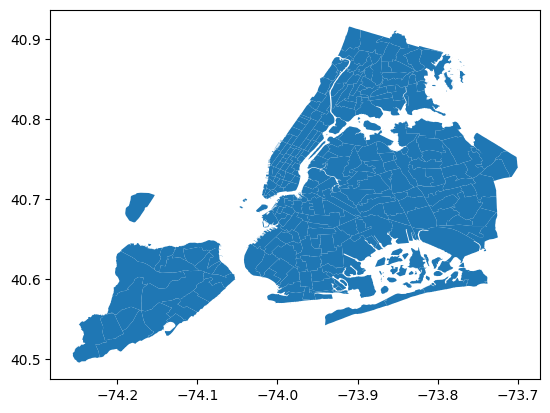

In [ ]:
import geopandas as gpd
from sodapy import Socrata
from shapely.geometry import shape

client = Socrata("data.cityofnewyork.us", None)
client.timeout = 1000
city = gpd.GeoDataFrame(client.get("755u-8jsi", limit=1000))
geometries_series = city['the_geom']
shapely_geometries = geometries_series.apply(lambda x: shape(x))
geo = gpd.GeoDataFrame(geometry=shapely_geometries)
city['the_geom'] = geo
city = city.set_geometry('the_geom')
city.plot()

In [ ]:
city

objectid       shape_leng  \
0          1   0.116357453189   
1          2    0.43346966679   
2          3  0.0843411059012   
3          4  0.0435665270921   
4          5  0.0921464898574   
..       ...              ...   
258      256  0.0679149669603   
259      259   0.126750305191   
260      260   0.133514154636   
261      261  0.0271204563616   
262      262  0.0490636231541   

                                              the_geom          shape_area  \
0    MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...     0.0007823067885   
1    MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...    0.00486634037837   
2    MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ...   0.000314414156821   
3    MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ...   0.000111871946192   
4    MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ...   0.000497957489363   
..                                                 ...                 ...   
258  MULTIPOLYGON (((-73.95834 40.71331, -73.95681 ...   0.000168611097013   
259  MULTIPOLYGON (((-73.85107 40.91037, -73.85207 ...   0.000394552487366   
260  MULTIPOLYGON (((-73.90175 40.76078, -73.90147 ...   0.000422345326907   
261  MULTIPOLYGON (((-74.01333 40.70503, -74.01327 ...  0.0000343423231652   
262  MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...   0.000122330270966   

                          zone location_id        borough  
0               Newark Airport           1            EWR  
1                  Jamaica Bay           2         Queens  
2      Allerton/Pelham Gardens           3          Bronx  
3                Alphabet City           4      Manhattan  
4                Arden Heights           5  Staten Island  
..                         ...         ...            ...  
258  Williamsburg (South Side)         256       Brooklyn  
259         Woodlawn/Wakefield         259          Bronx  
260                   Woodside         260         Queens  
261         World Trade Center         261      Manhattan  
262             Yorkville East         262      Manhattan  

[263 rows x 7 columns]

```
explicar a criação do heatmap e a união das imagens geradas para o video
```



In [ ]:
import cv2
import os

def getHeatMap(df_real, df_pred, future, path, fps=2):
    colors = plt.colormaps.get_cmap('gist_heat').reversed()
    for i in range(0, len(df_real)):
        # Plotting the comparation of Predict and Real Heatmap
        fig, axs = plt.subplots(1, 2, figsize=(10, 10))
        graph1 = city.plot(column=df_pred.values[i], cmap=colors, vmin=-1, vmax=df_pred.mean().mean(), ax=axs[0])
        graph1.set_axis_off()
        axs[0].set_title("Predict")
        graph2 = city.plot(column=df_real.values[i], cmap=colors, vmin=-1, vmax=df_real.mean().mean(), ax=axs[1])
        graph2.set_axis_off()
        axs[1].set_title("Real")

        # Plotting the Colorbar
        fig = fig.get_figure()
        cax = fig.add_axes([0.53, 0.4, 0.01, 0.2])
        cbar = fig.colorbar(graph1.collections[0], cmap="Reds", cax=cax)
        cbar.set_label('NYC Taxi Request')
        cbar.ax.yaxis.set_ticks_position('left')

        # Saving the
        time = (pd.to_datetime(future) + pd.Timedelta(hours=i*24/len(df_real))).strftime("%H:%M (%m/%d/%y)")
        fig.suptitle(time, x=0.53, y=0.69, fontsize=15)
        fig.savefig(path + 'heatmap' + (str(i).zfill(3)) + '.png')  # Saves len(dataframe) images

    # Making the Video with Images
    images = [img for img in os.listdir(path) if img.endswith(".png")]
    images.sort()
    widht, height = cv2.imread(os.path.join(path, images[0])).shape[:2]
    video = cv2.VideoWriter('heatmap_video.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, (widht, height))

    for image in images:
        image_path = os.path.join(path, image)
        frame = cv2.imread(image_path)
        video.write(frame)

    video.release()

```
explicar finalização usando função do LSTM para criar um dataframe com as previsões de pedidos do dia escolhido por periodo definido e geração do video do heatmap
```



<ipython-input-143-bcab3fc991dc>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=(10, 10))


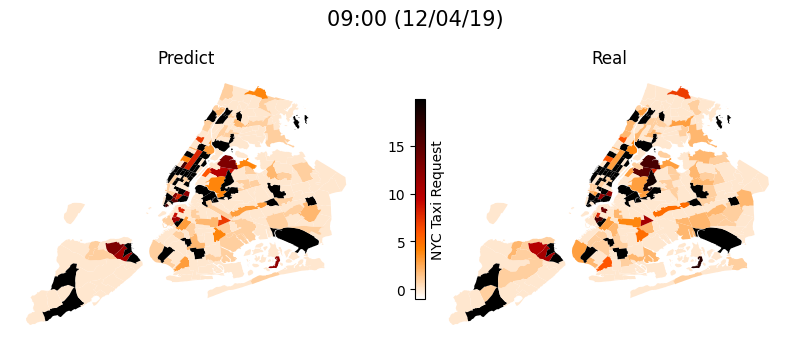

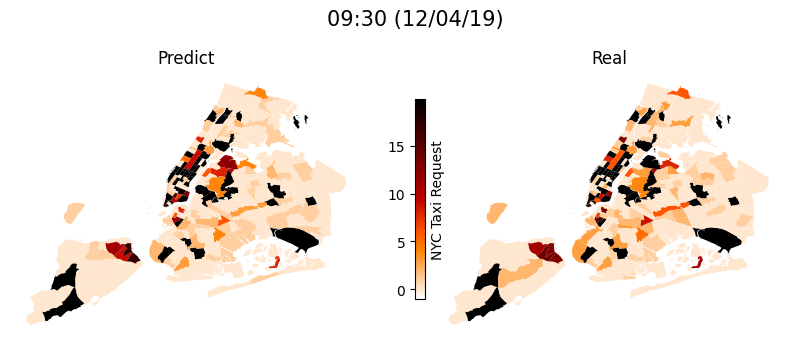

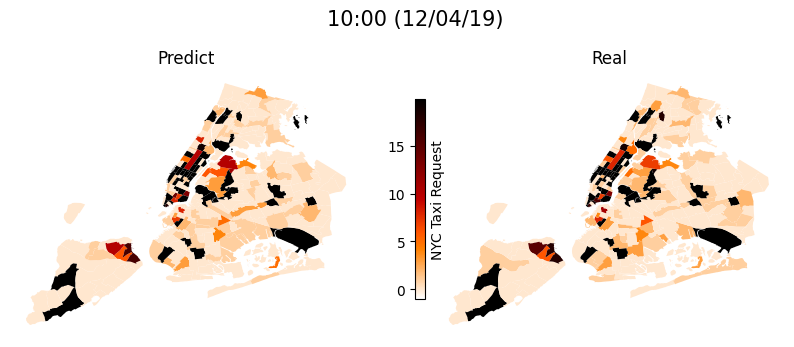

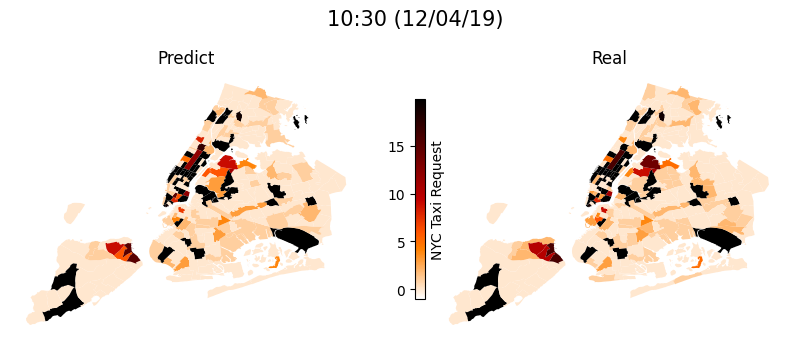

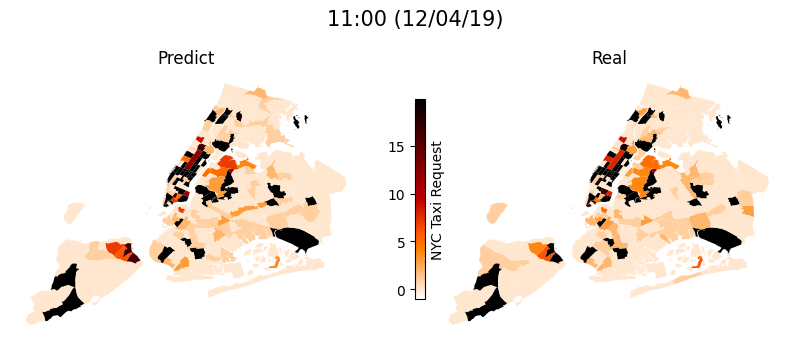

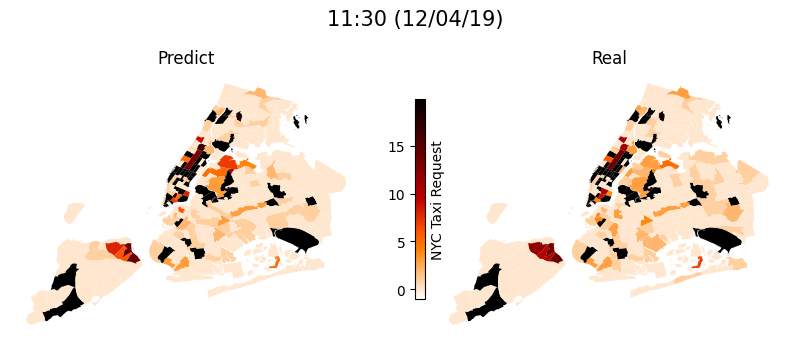

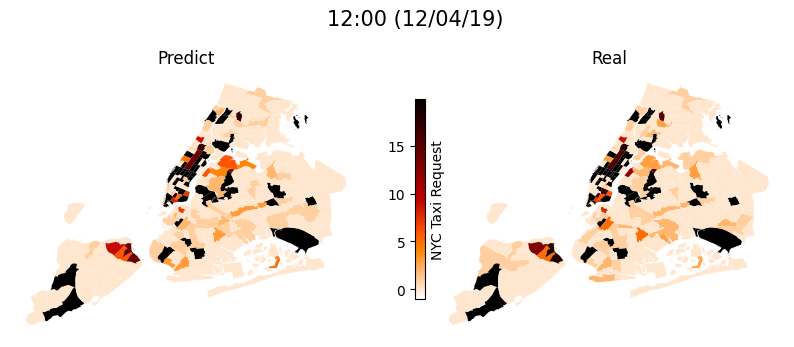

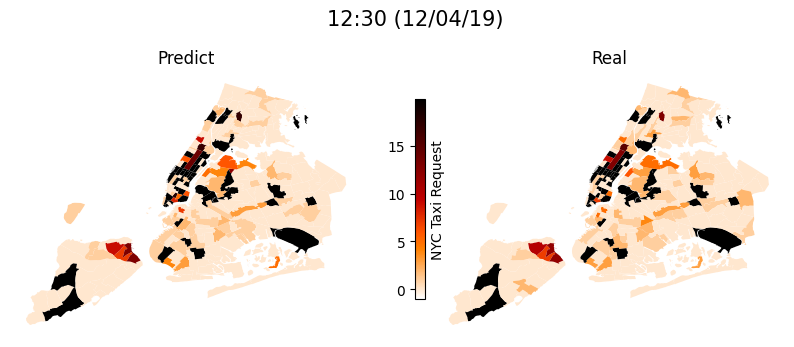

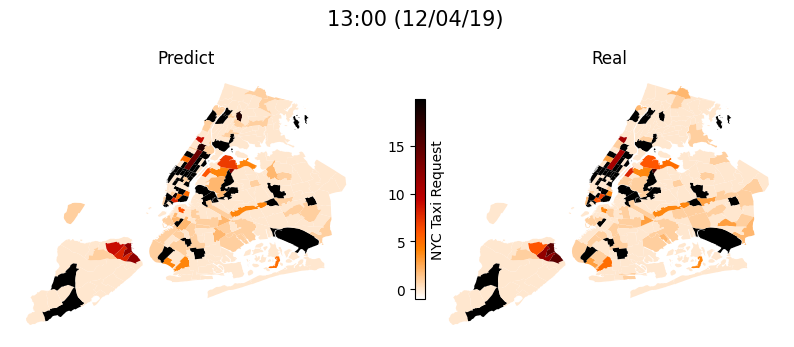

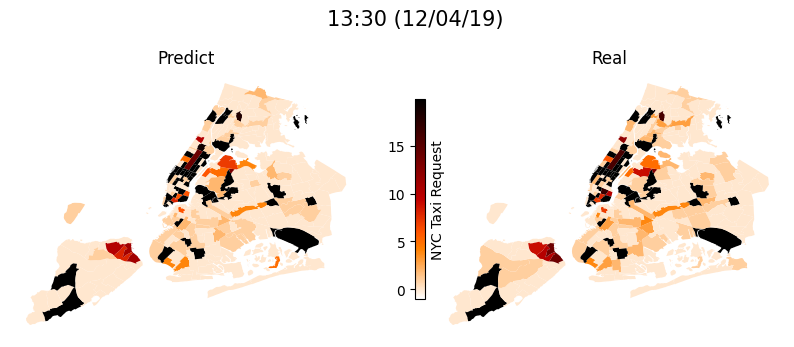

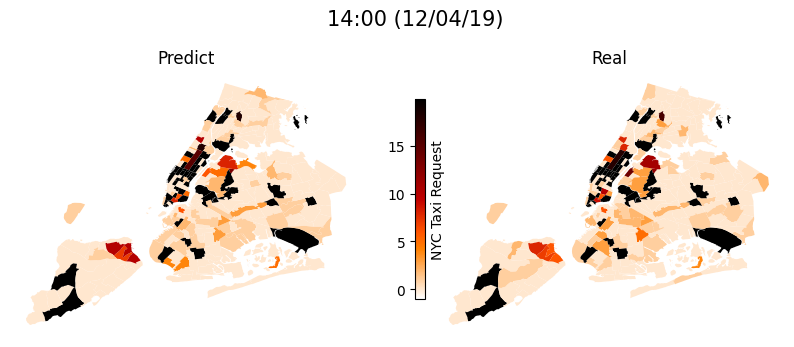

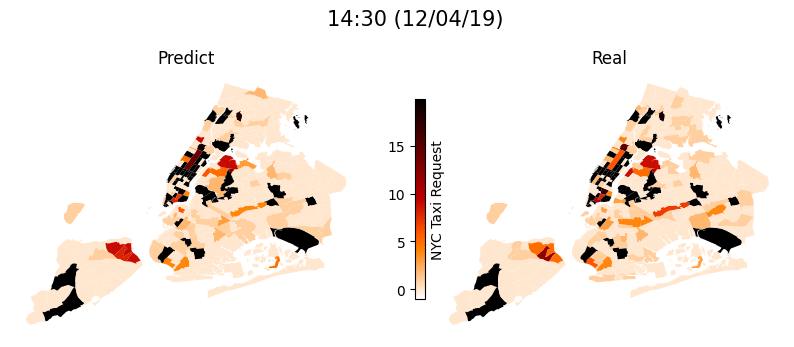

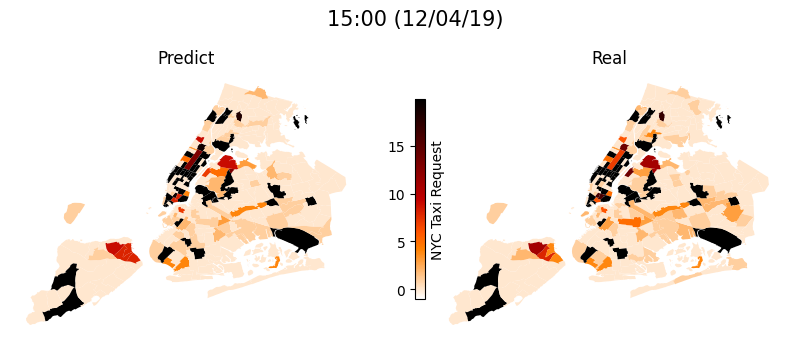

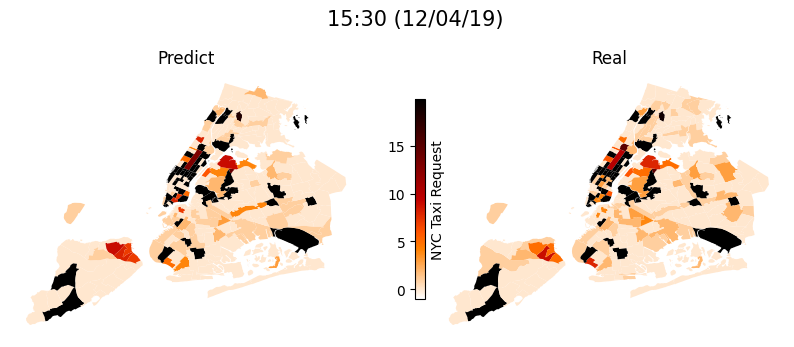

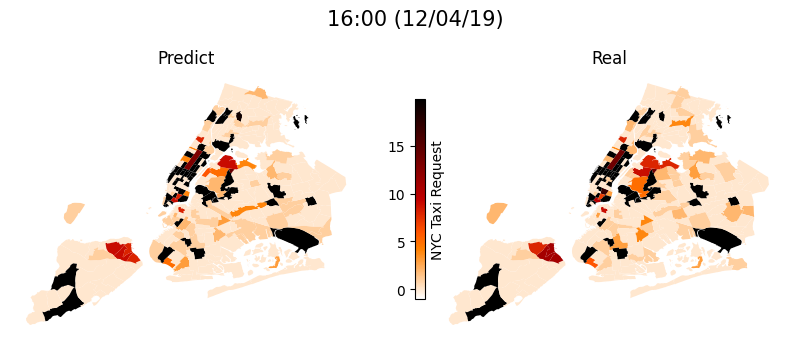

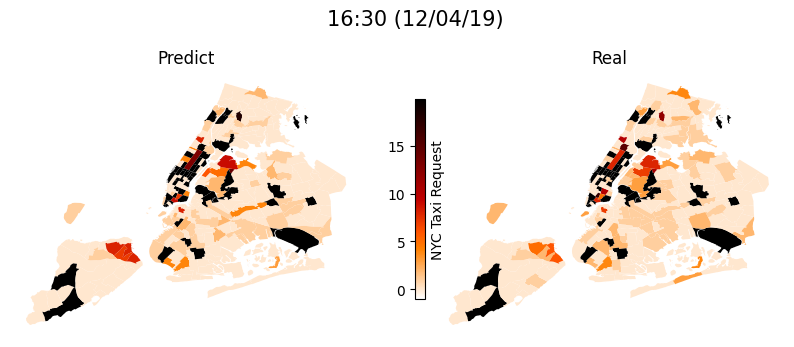

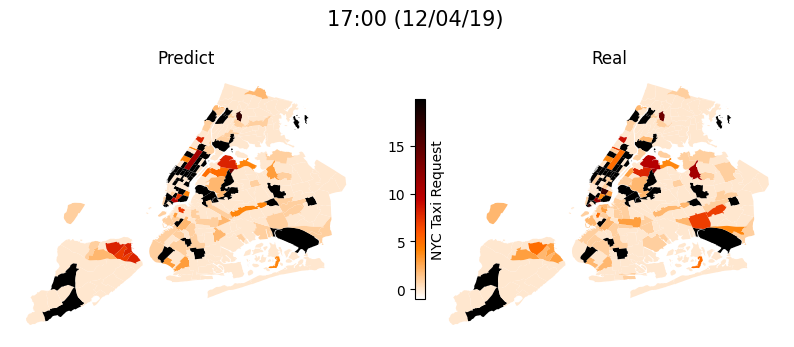

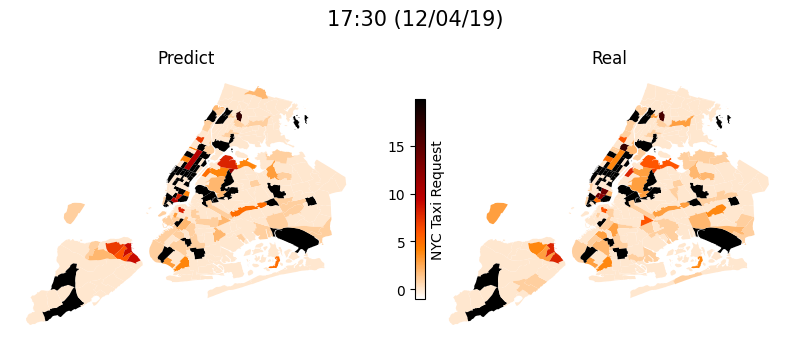

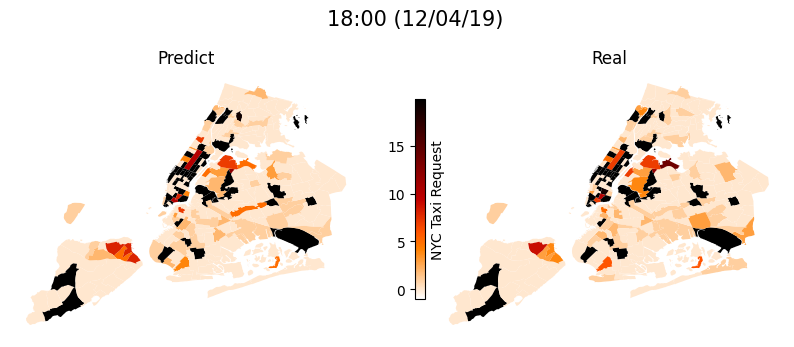

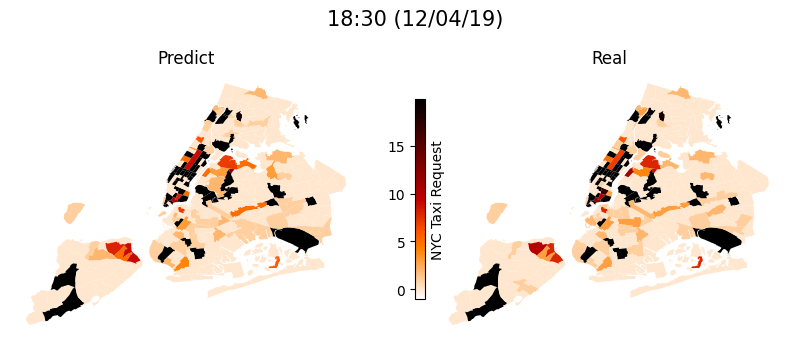

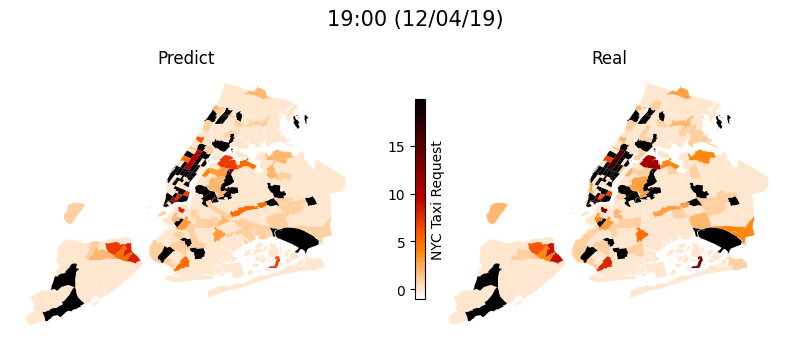

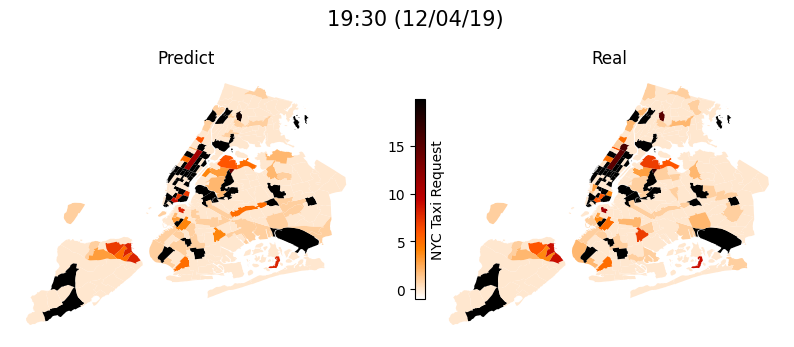

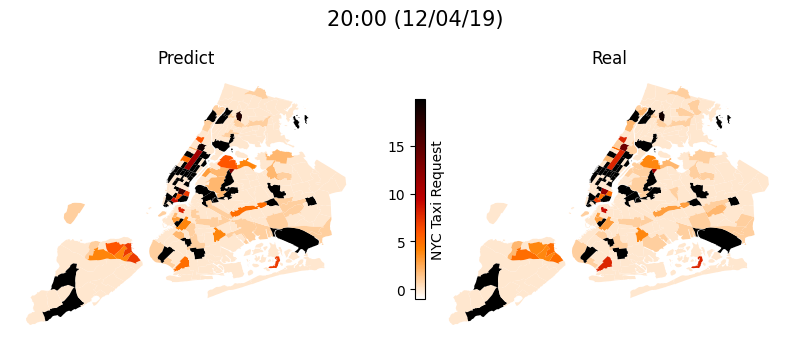

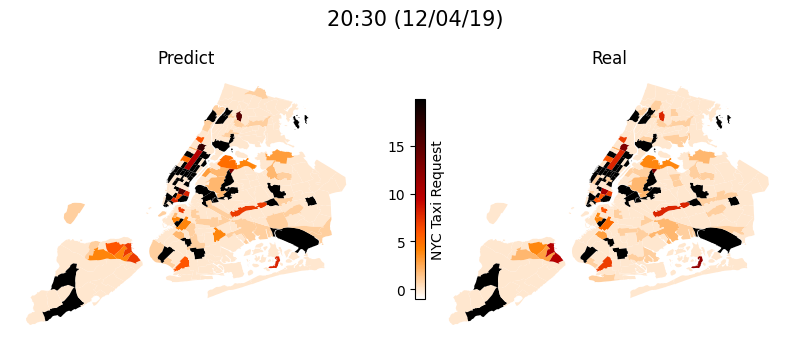

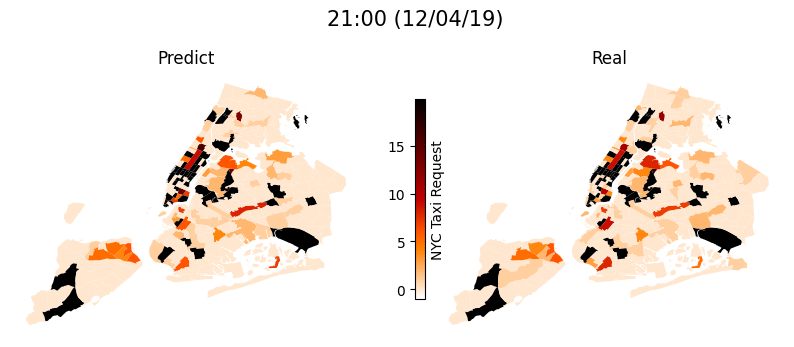

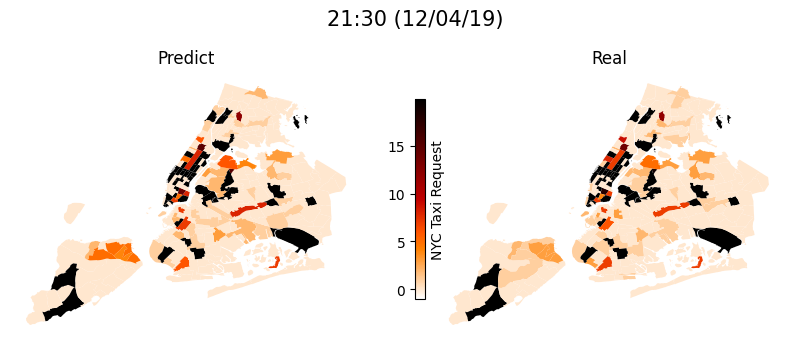

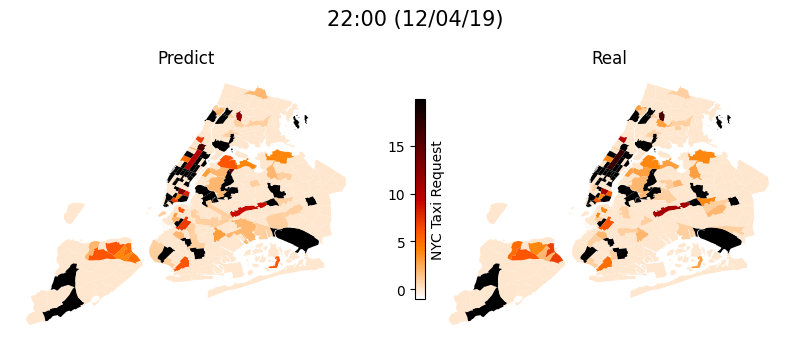

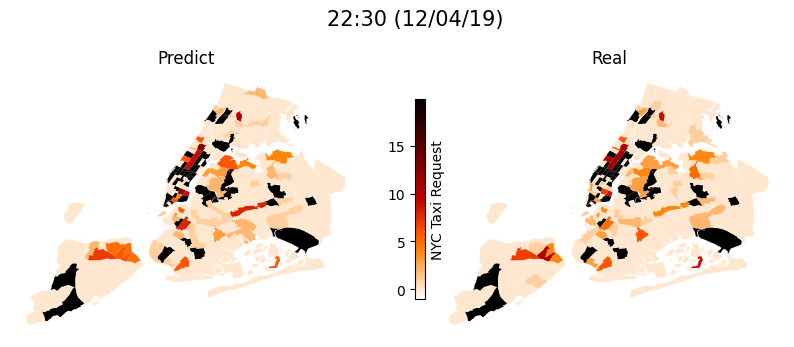

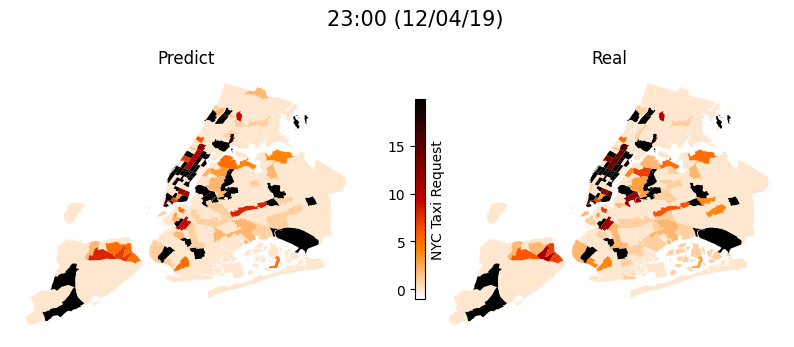

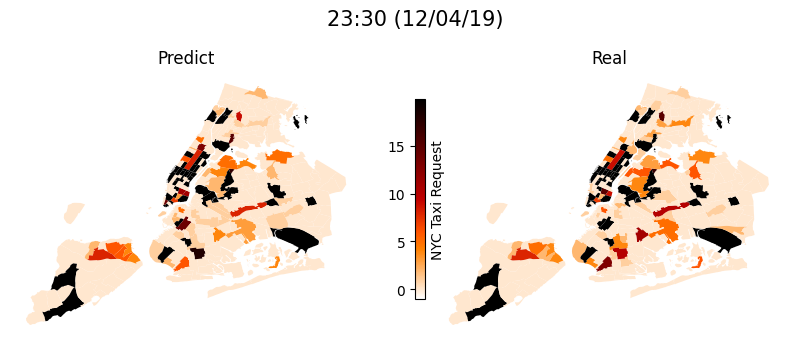

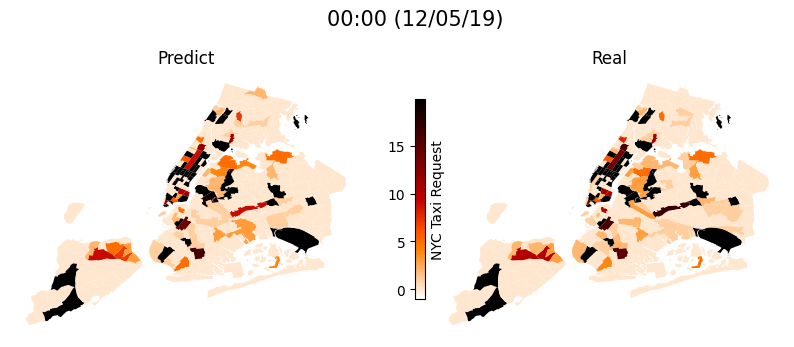

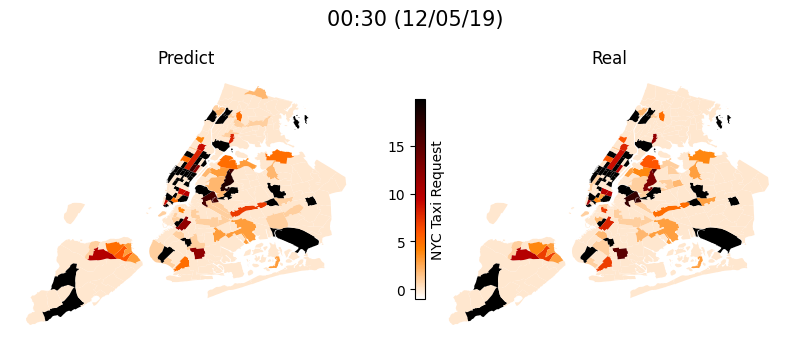

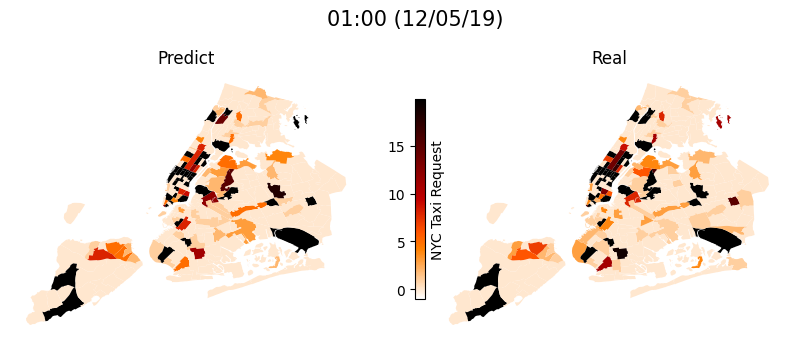

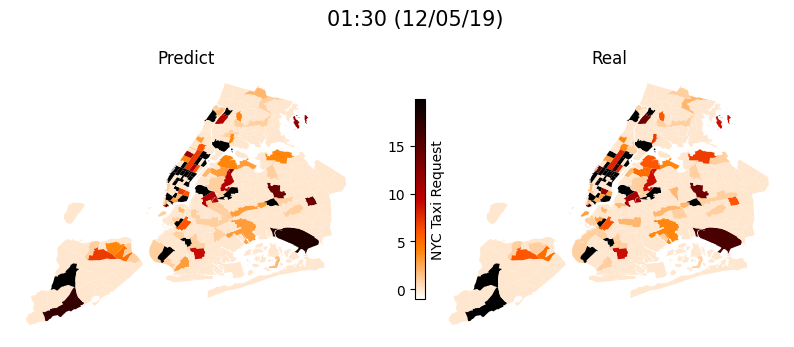

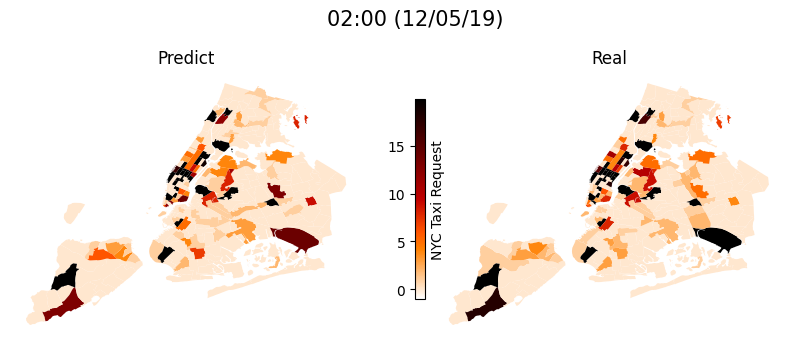

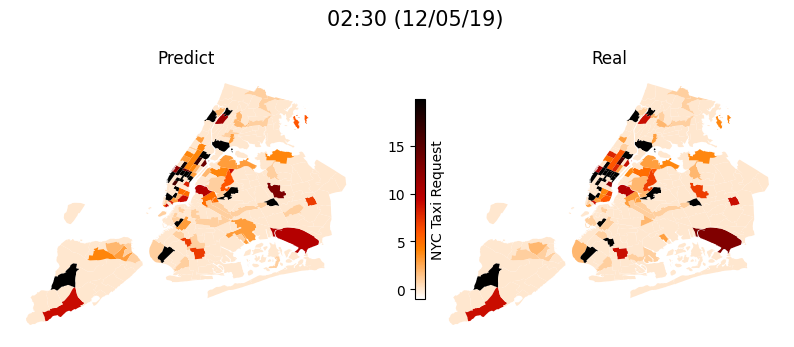

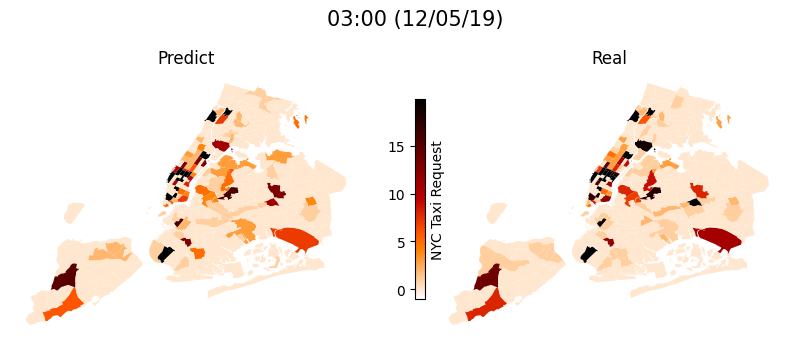

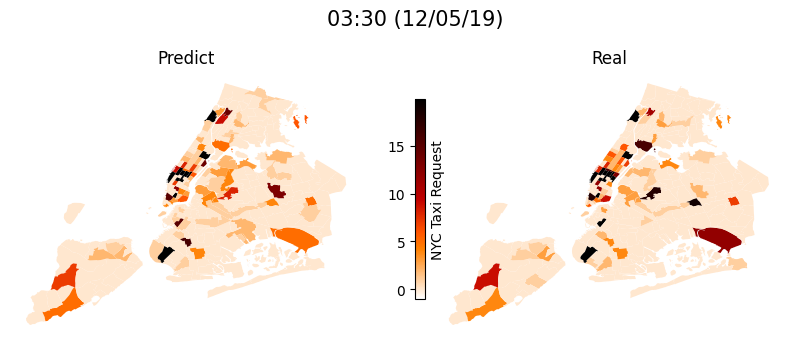

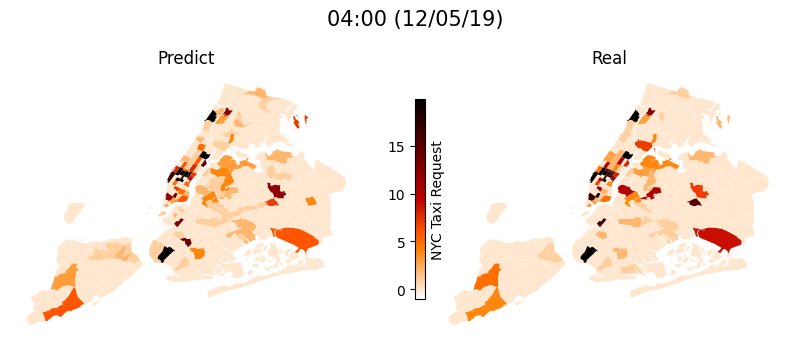

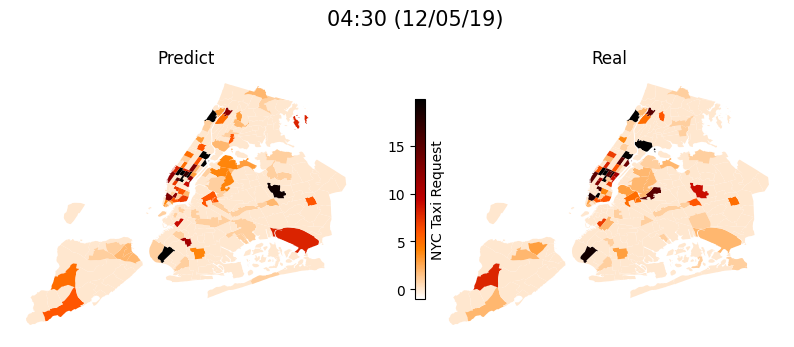

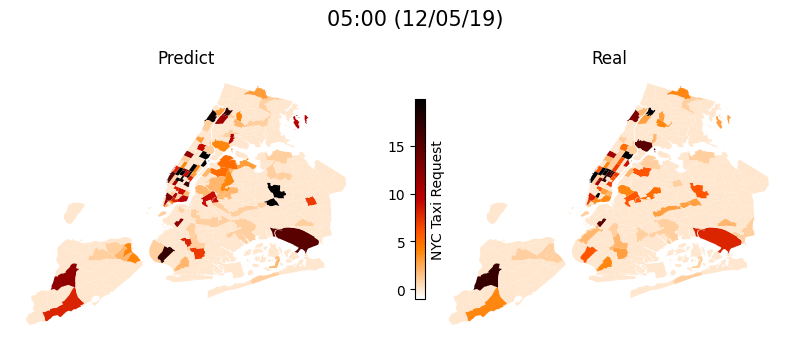

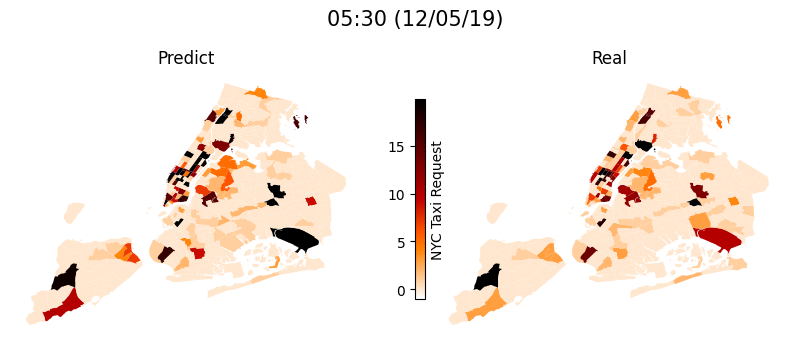

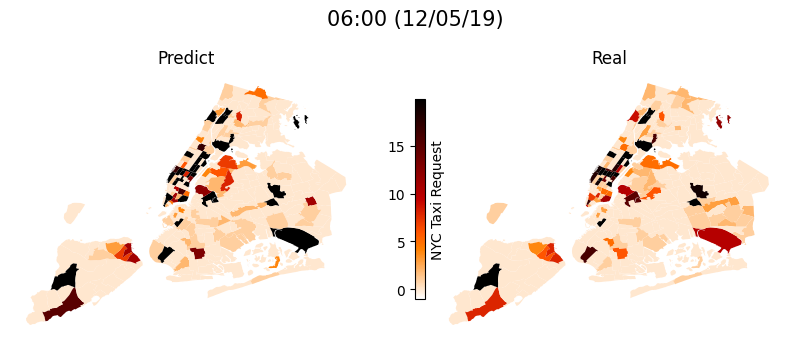

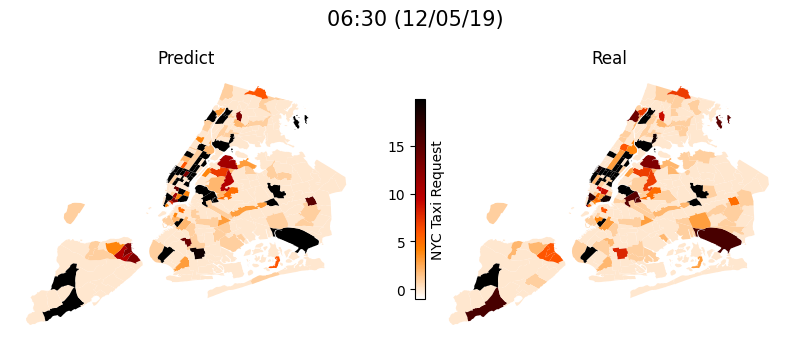

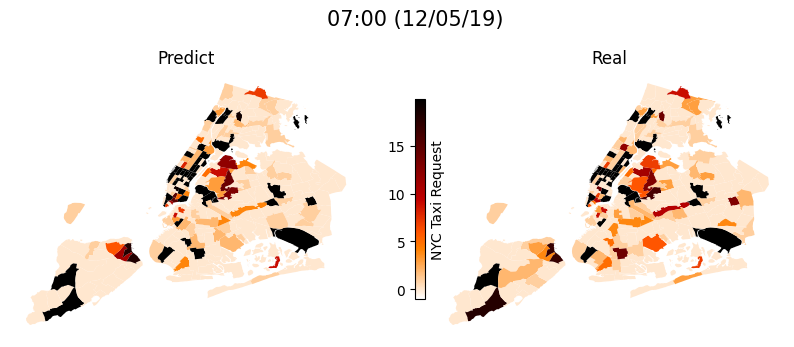

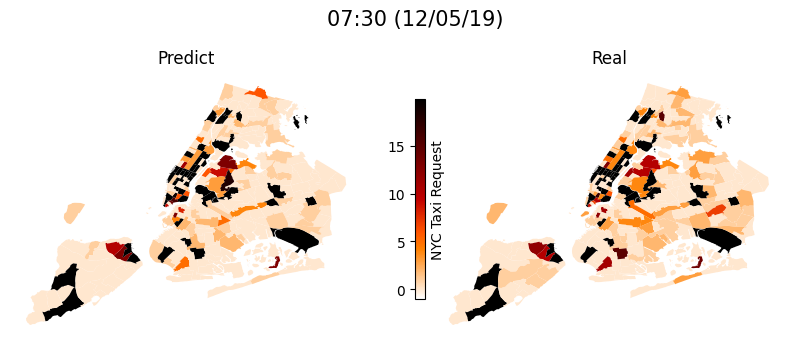

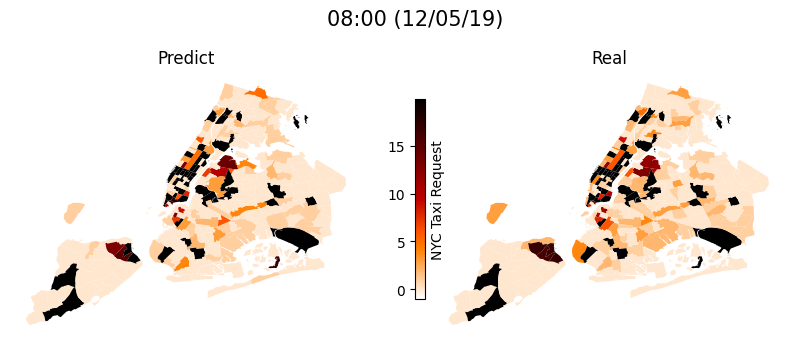

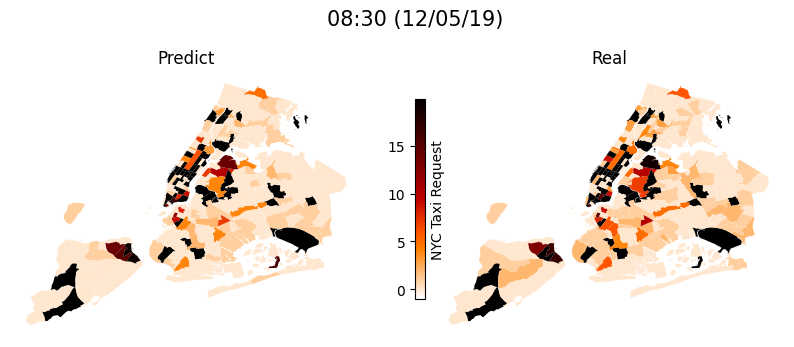

In [ ]:
START_PREDICTION = "2019-12-04 09:00:00"
PATH = '/content/images/'
zonelist = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/taxi-zone-lookup.csv")

# LSTM
#realNYC, predNYC = nycLSTM(START_PREDICTION, zonelist['LocationID'].values)

# HEATMAP
getHeatMap(realNYC, round(predNYC), START_PREDICTION, PATH, fps=1)

---
# **Referências**
---

https://www.cs.columbia.edu/~lierranli/publications/TSW2017_paper.pdf

https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc

https://data.cityofnewyork.us/Transportation/2019-Yellow-Taxi-Trip-Data/2upf-qytp

https://holowczak.com/getting-started-with-nyc-opendata-and-the-socrata-api/5/

https://www.youtube.com/watch?v=c0k-YLQGKjY&t=1375s